In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.codification_skipc import ChromosomeSkip, Connections
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA, TwoLevelGA


Using TensorFlow backend.


In [9]:
# Chromosome parameters
mutation_rate = 0.05
mutation_rate_1 = mutation_rate * 2
ChromosomeSkip.grow_prob = mutation_rate_1
ChromosomeSkip.decrease_prob = mutation_rate_1

CNNLayer.k_prob = mutation_rate
CNNLayer.filter_prob = mutation_rate_1
CNNLayer.act_prob = mutation_rate
CNNLayer.drop_prob = mutation_rate_1
CNNLayer.maxpool_prob = mutation_rate

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1

CNNLayer.filters_lim = 128

'''
data_folder = '../../datasets'
command = 'python3 ./train_gen.py'
verbose = 0
experiments_folder = '../../exps'
gpus = 2
skip = True

'''
data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./../train_gen.py'
verbose = 1
experiments_folder = '../exps_testing'
gpus = 1
skip = 1

In [13]:
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)

fitness_cnn = FitnessCNN()

l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3])
if skip:
    c = ChromosomeSkip(c.cnn_layers, c.nn_layers, Connections.random_connections(len(c.cnn_layers)))
    

In [18]:
d = c.random_individual()

In [19]:
print(d)

CNN|F:124|K:(1,7)|A:leakyreLu|D:0.429|M:1
CNN|F:73|K:(1,1)|A:relu|D:0.272|M:1
CNN|F:73|K:(3,1)|A:prelu|D:0.956|M:0
CNN|F:95|K:(1,1)|A:tanh|D:0.131|M:1
NN|U:945|A:leakyreLu|D:0.810
1
11
001



In [20]:
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
generations=3
population_first_level=4
population_second_level=2
training_hours=1
save_progress=False
maximize_fitness=False
statistical_validation=True
frequency_second_level=2
start_level2 = 2


# Fitness params
epochs = 4
batch_size = 256
verbose = verbose
redu_plat = False
early_stop = 15
warm_up_epochs= 0
base_lr = 0.02
smooth = 0.1
cosine_dec = False
lr_find = False
precise_eps = 8

datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['mnist']


EVOLVING IN DATASET mnist ...

(6400, 28, 28, 1) train samples
(1600, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples
Population size level one: 4
Population size level two: 2
Number of parents level one: 1
Number of parents level two: 1
Offspring size level one: 3
Offspring size level two: 1
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 3
Population size: 4
num parents: 1
offspring size: 3

Creating Initial population

Start evolution process...


0) Ranking level 1... Models to train: 4 ...OK (in 1.33 minutes)
Statistical validation in 1.74 minutes

1) Ranking level 1... Models to train: 3 ...OK (in 0.79 minutes)
Statistical validation in 0.00 minutes

2) Ranking level 1... Models to train: 3 ...OK (in 0.98 minutes)
Statistical validation in 0.00 minutes

2) Ranking level 2... Models to train: 2 ...OK (in 1.51 minutes)

3) Ranking level 1... Models to train: 3 ...OK (in 1.59 minutes)
Statistical validation in 0.00 minutes

3

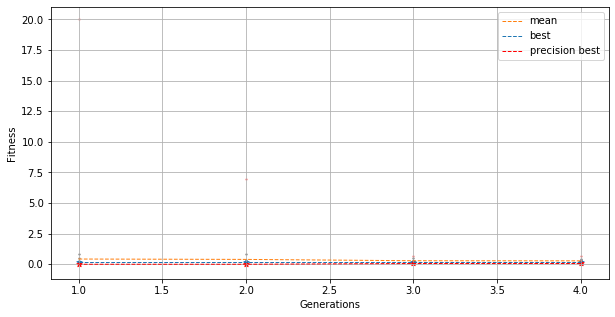

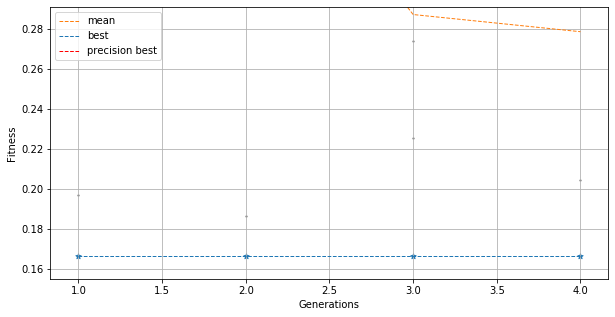

Total elapsed time: 570.436


In [21]:
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)

    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, max_examples=8000)
    data = dm.load_data()
    fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)

    fitness_cnn.save(fitness_file)

    del dm, data
    
    fitness = FitnessCNNParallel()
    fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                   fp=32, main_line=command)
    generational = TwoLevelGA(chromosome=c,
                              fitness=fitness,
                              generations=generations,
                              population_first_level=population_first_level,
                              population_second_level=population_second_level,
                              training_hours=training_hours,
                              save_progress=save_progress,
                              maximize_fitness=maximize_fitness,
                              statistical_validation=statistical_validation,
                              folder=folder,
                              start_level2=start_level2,
                              frequency_second_level=frequency_second_level)
        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
ranking1 = generational.evaluate_population(level=1)
ranking2 = generational.evaluate_population(level=2)

In [ ]:
ranking1

In [ ]:
ranking2

In [ ]:
w = generational.best_individual['winner']

In [ ]:
print(generational.history_fitness[w.__repr__()])
print(generational.history_precision_fitness[w.__repr__()])

In [ ]:
generational.best_individual

In [ ]:
for k,f in generational.history_precision_fitness.items():
    print(k,f, end="\n"*2)